In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from pyspark.sql import SparkSession

# instantiate SparkSession object
# spark = SparkSession.builder.master('local').getOrCreate()

spark = SparkSession\
        .builder\
        .appName('ALSExample').config('spark.driver.host', 'localhost')\
        .getOrCreate()

In [3]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
import pyspark as spark
spark = SparkSession.builder.appName('Recommendation_system').getOrCreate()
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

In [4]:
reviews = pd.read_csv('./data/ml-latest-small/ratings.csv')
links = pd.read_csv('./data/ml-latest-small/links.csv')
movies = pd.read_csv('./data/ml-latest-small/movies.csv')
tags = pd.read_csv('./data/ml-latest-small/tags.csv')

In [4]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [5]:
reviews.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


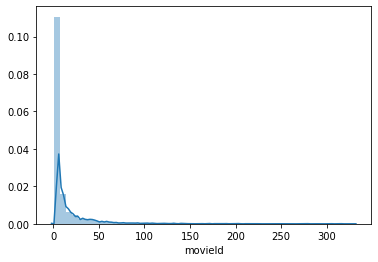

In [6]:
sns.distplot(reviews.movieId.value_counts())

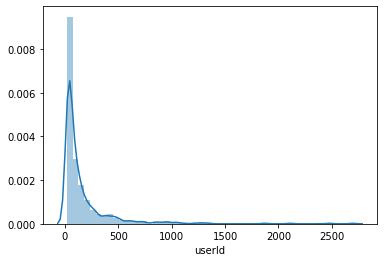

In [7]:
sns.distplot(reviews.userId.value_counts())

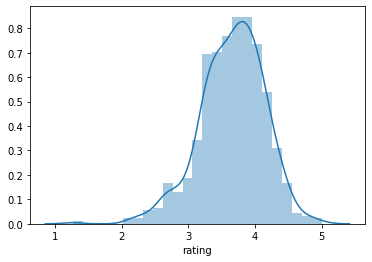

In [8]:
sns.distplot(reviews.groupby('userId')['rating'].mean())

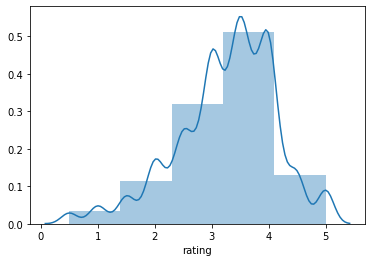

In [9]:
sns.distplot(reviews.groupby('movieId')['rating'].mean(),bins=5)

In [10]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [21]:
movies['genres'] = movies['genres'].apply(lambda x: x.split('|'))

# Spark ALS Model

In [22]:
movie_ratings = spark.read.csv('./data/ml-latest/ratings.csv', header='true', inferSchema='true')
movie_ratings = movie_ratings.drop('timestamp')

In [23]:
# split into training and testing sets
(training, test) = movie_ratings.randomSplit([0.8, 0.2])

# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(maxIter=5,rank=4, regParam=0.01, userCol='userId', itemCol='movieId', ratingCol='rating',
          coldStartStrategy='drop')

# fit the ALS model to the training set
model = als.fit(training)

In [24]:
# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating',
                                predictionCol='prediction')
rmse = evaluator.evaluate(predictions)
print('Root-mean-square error = ' + str(rmse))

Root-mean-square error = 0.8398568465709946


In [25]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [26]:
# initialize the ALS model
als_model = ALS(userCol='userId', itemCol='movieId', 
                ratingCol='rating', coldStartStrategy='drop')

# create the parameter grid                 
params = ParamGridBuilder()\
          .addGrid(als_model.regParam, [0.01, 0.001, 0.1])\
          .addGrid(als_model.rank, [4, 10, 50]).build()


# instantiating crossvalidator estimator
cv = CrossValidator(estimator=als_model, estimatorParamMaps=params,evaluator=evaluator,parallelism=4)
best_model = cv.fit(movie_ratings)    

# We see the best model has a rank of 50, so we will use that in our future models with this dataset
best_model.bestModel.rank

KeyboardInterrupt: 

In [27]:
def new_user_recs(user_id, new_ratings, rating_df, movie_title_df, num_recs):
    # turn the new_recommendations list into a spark DataFrame
    movie_id_list = []
    new_user_ratings = spark.createDataFrame(new_ratings,rating_df.columns)
    
    # combine the new ratings df with the rating_df
    movie_ratings_combined = rating_df.union(new_user_ratings)
    
    # split the dataframe into a train and test set
#     (training, test) = movie_ratings_combined.randomSplit([0.8, 0.2],seed=0)
    
    # create an ALS model and fit it
    als = ALS(maxIter=5, rank=50, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
    model = als.fit(movie_ratings_combined)
    
    # make recommendations for all users using the recommendForAllUsers method
    recommendations = model.recommendForAllUsers(num_recs)
    
    # get recommendations specifically for the new user that has been added to the DataFrame
    recs_for_user = recommendations.where(recommendations.userId == user_id).take(1)
    
    for ranking, (movie_id, rating) in enumerate(recs_for_user[0]['recommendations']):
        movie_string = name_retriever(movie_id, movie_title_df)
        movie_id_list.append(movie_id)
        print(movie_id)
        print('Recommendation {}: {}  | predicted score :{}'.format(ranking+1, movie_string, rating))
        
    return movie_id_list

In [28]:
def name_retriever(movie_id, movie_title_df):
    return movie_title_df.where(movie_title_df.movieId == movie_id).take(1)[0]['title']

In [ ]:
movie_titles = spark.read.csv('./data/ml-latest/movies.csv', header='true', inferSchema='true')

In [ ]:
movies[(movies['movieId']==9692)]

In [ ]:
movies

In [ ]:
# try out your function with the movies listed above
user_id = 1000
user_ratings_1 = [(user_id,3257,5),
                  (user_id,2459,1),
                  (user_id,2513,2),
                  (user_id,6502,2),
                  (user_id,1091,2),
                  (user_id,441,4)]
new_user_recs(user_id,
             new_ratings=user_ratings_1,
             rating_df=movie_ratings,
             movie_title_df = movie_titles ,
             num_recs = 10)

# Making movie content filtering system

In [ ]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate

In [ ]:
movies = pd.read_csv('../../data/raw/movies.csv')

In [ ]:
movies

In [ ]:
movies['year'] = movies['title'].apply(lambda x: x[-5:-1].strip('('))

In [ ]:
movies['year'] = movies['year'].apply(lambda x: x.strip(')'))

In [ ]:
movies['year'] = movies['year'].apply(lambda x: x.strip('-'))

In [ ]:
movies = movies.drop(movies[movies['title'].str.contains("\(") == False].index)

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

In [ ]:
mlb = MultiLabelBinarizer()

res = pd.DataFrame(mlb.fit_transform(movies['genres']),
                   columns=mlb.classes_,
                   index=movies['genres'].index)

In [ ]:
genre_reviews = pd.merge(movies, res, left_index = True, right_index = True)

In [ ]:
genre_reviews

In [ ]:
genre_reviews = genre_reviews.drop(['genres'], axis = 1)

In [ ]:
## how do we deal with these??
genre_reviews.loc[genre_reviews['(no genres listed)'] == True]

In [ ]:
tags = pd.read_csv('../../data/raw/tags.csv')

In [ ]:
tags['joined_tags'] = tags.groupby('movieId')['tag'].transform(lambda x: ' '.join(x))

In [ ]:
tags

In [ ]:
tags = tags[['movieId', 'joined_tags']].drop_duplicates()

In [ ]:
tags

In [ ]:
tags.loc[tags.movieId == 1]

In [ ]:
avg_review = pd.DataFrame(reviews.groupby('movieId')['rating'].mean())

In [ ]:
avg_review['no_of_ratings'] = reviews.groupby('movieId')['rating'].count()

In [ ]:
movies_ratings = genre_reviews.merge(avg_review, how = 'inner', on = 'movieId')

In [ ]:
movies_ratings

# NLTK

In [ ]:
from nltk import *
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from rake_nltk import Rake

In [ ]:
movies_w_tags['joined_tags'] = movies_w_tags['joined_tags'].apply(lambda x: x.replace(',', ''))

In [ ]:
def combine_tags_genres(movies, tags):
    df = movies.merge(tags, on='movieId', how='outer')
    df['genres'] = df['genres'].apply(lambda x: ' '.join([str(elem) for elem in x]) )
    df = df[df['title'].isna()==False]
    df.loc[df['joined_tags'].isnull(),['joined_tags']] = df.loc[df['joined_tags'].isnull(),'joined_tags'].apply(lambda x:[])

    df['keywords'] = df['genres'] +' '+ df['joined_tags'].map(str)
    df = df.drop(['joined_tags'], axis=1)
    df['genres'] = df['genres'].apply(lambda x: x.split(' '))
    
    
    return df

In [ ]:
movies_w_tags = combine_tags_genres(movies, tags)

### Rake

In [ ]:
# movies_w_tags['joined_tags'] = movies_w_tags['joined_tags'].apply(lambda x: x.split(', '))

In [ ]:
# movies_w_tags['keywords'] = movies_w_tags['genres']+movies_w_tags['joined_tags']

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
def count_vec(df):
    count_vect = CountVectorizer(stop_words='english')
    counts = count_vect.fit_transform(df.keywords)
    cos_sim = cosine_similarity(counts, counts)
    
    return cos_sim
def recommendations(title, cos_sim = cos_sim):
    
    # initializing the empty list of recommended movies
    recommended_movies = []
    
    # gettin the index of the movie that matches the title
    idx = indices[indices == title].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cos_sim[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar movies
    top_10_indexes = list(score_series.iloc[1:11].index)
    
    # populating the list with the titles of the best 10 matching movies
    for i in top_10_indexes:
        recommended_movies.append(list(movies_w_tags.index)[i])
        
    return recommended_movies

In [ ]:
recommendations(0, count_vec(movies_w_tags))

In [ ]:
print(movies_w_tags.loc[movies_w_tags.index == 0])

In [ ]:
print(movies_w_tags.loc[movies_w_tags.index == 7760])

## TFIDF

In [427]:
vectorizer = TfidfVectorizer(stop_words = 'english')
X = vectorizer.fit_transform(movies_w_tags.keywords)
tfidf_cos = cosine_similarity(X, X)
recommendations(1, tfidf_cos)

[9692, 6254, 9565, 7426, 6389, 53, 1514, 9336, 8719, 767]

In [428]:
def tfidf_recs(title, cos_sim = tfidf_cos):
    
    # initializing the empty list of recommended movies
    recommended_movies = []
    
    # gettin the index of the movie that matches the title
    idx = indices[indices == title].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cos_sim[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar movies
    top_10_indexes = list(score_series.iloc[1:21].index)
    
    # populating the list with the titles of the best 10 matching movies
    for i in top_10_indexes:
        recommended_movies.append(list(movies_w_tags.index)[i])
        
    return title, recommended_movies

In [429]:
tfidf_recs(0)

(0,
 [1757,
  2355,
  8695,
  9430,
  8219,
  3568,
  3000,
  8927,
  2809,
  6948,
  7760,
  1706,
  6194,
  6486,
  8900,
  6944,
  5087,
  2539,
  3230,
  3336])

In [632]:
def genre_choose(rec_outputs, movies):
    match_list = []
#     count = 0
    original_movie_genres = movies.loc[movies.index == rec_outputs[0]]['genres'][(rec_outputs[0])]
    for i in rec_outputs[1]:
        movie = movies.loc[movies.index == i]['genres'].values[0]
        for genre in movie:
#             count = 0
            for genrez in original_movie_genres:
#                 count = 0
#                 print(genrez)
#                 print(genre)
                if genrez == genre:
                    match_list.append(movies[movies.index == i]['title'])
#                     print(count)
#                     count = count + 1
    return match_list
            
            

In [652]:
print(movies_w_tags.loc[movies_w_tags.index == 758])
genre_choose(tfidf_recs(758), movies_w_tags)

     movieId             title                        genres  year  \
758     3877  Supergirl (1984)  [Action, Adventure, Fantasy]  1984   

                               keywords  
758  Action Adventure Fantasy superhero  


[607    Mystery Men (1999)
 Name: title, dtype: object, 607    Mystery Men (1999)
 Name: title, dtype: object, 43    Batman Forever (1995)
 Name: title, dtype: object, 43    Batman Forever (1995)
 Name: title, dtype: object, 590    Superman III (1983)
 Name: title, dtype: object, 590    Superman III (1983)
 Name: title, dtype: object, 588    Superman (1978)
 Name: title, dtype: object, 588    Superman (1978)
 Name: title, dtype: object, 380    Batman Returns (1992)
 Name: title, dtype: object, 897    Spider-Man (2002)
 Name: title, dtype: object, 897    Spider-Man (2002)
 Name: title, dtype: object, 145    Batman (1989)
 Name: title, dtype: object, 589    Superman II (1980)
 Name: title, dtype: object, 751    X-Men (2000)
 Name: title, dtype: object, 751    X-Men (2000)
 Name: title, dtype: object, 1482    Man of Steel (2013)
 Name: title, dtype: object, 1482    Man of Steel (2013)
 Name: title, dtype: object, 1482    Man of Steel (2013)
 Name: title, dtype: object, 1034    Pirates of 

In [441]:
movies.loc[movies.index == 1281]


,movieId,title,genres,year
1281,1701,Deconstructing Harry (1997),"[Comedy, Drama]",1997


In [443]:
recommendations(0)

[544, 666, 1033, 812, 643, 160, 1444, 1281, 1274, 248]

## input userId and movieId

In [886]:
user_id = 1
movie_id = 1
num_recs = 10
genre_input = "Comedy"

In [634]:
def user_exist(uid, reviews):
    if uid in reviews.userId:
        return True
    else:
        return False
    
def get_ratings(uid, reviews):
    user_ratings=[]
    temp = reviews[reviews['userId']==uid].loc[:,['movieId', 'rating']]
    for index, row in temp.iterrows():
        user_ratings.append((uid, int(row['movieId']), float(row['rating'])))
    return user_ratings

def name_retriever_index(movie_id, titles):
    return list(titles[titles.index==movie_id]['title'])

def get_titles(movie_ids, movie_titles):
    titles = []
    for mid in movie_ids:
        print(name_retriever_index(mid, movie_titles))

In [ ]:
def get_top_genre(person_recommend, genre):
    movie_list = []
    for i in person_recommend[0][1]:
        movie = i[0]
        info = name_retriever(movie,movie_titles)
        title = info[0]
        genres = info[1].split('|')
        for j in genres:
            for k in genre:
                if j == k:
                    movie_list.append((title, genres))
    return movie_list[:5]

In [883]:
def get_movie_choose_genre(movie_ids, genre, movies):
    movie_in_genre = []
    for mid in movie_ids:
        temp = movies[movies.index==mid]
        for genres_list in temp['genres']:
            for each_genres in genres_list:
                if genre == each_genres:
                    movie_in_genre.append(mid)         
    return movie_in_genre      

In [889]:
user_id = 1
movie_id = 1
num_recs = 10
genre_input = "Comedy"

In [ ]:
print("user:", user_id)
print("movie:", movies[movies['movieId']==movie_id]['title'])
print("========================")
new_ratings = get_ratings(user_id, reviews)
print("Collaborative:")
if (user_exist(user_id, reviews)):
    movie_id_list = new_user_recs(user_id, new_ratings, movie_ratings, movie_titles, 5)
    
print("Content:")
get_titles(tfidf_recs(movie_id)[1], movies)


In [ ]:
def content_after_collab(movie_id_index, movies):
    for mid in movies.index:
        get_titles(tfidf_recs(mid)[1], movies)


In [ ]:
def get_index(movieId_list, movies):
    movieIndex_list = []
    for mid in movieId_list:
        movieIndex_list.append(movies[movies['movieId']==mid].index[0])
    return movieIndex_list

In [ ]:
content_after_collab(get_index(movie_id_list,movies), movies)

In [894]:
get_titles(get_movie_choose_genre(tfidf_recs(1262)[1], genre_input, movies), movies)


['Mean Machine (2001)']
['House of Yes, The (1997)']
['Indian Summer (a.k.a. Alive & Kicking) (1996)']
['Full Monty, The (1997)']
['Stroszek (1977)']
['Little Miss Marker (1980)']
['Imaginary Heroes (2004)']
['Rare Birds (2001)']
['Life and Death of Peter Sellers, The (2004)']
['Oh Boy (A Coffee in Berlin) (2012)']
['Employee of the Month (2004)']
['In the Company of Men (1997)']
['Our Brand Is Crisis (2015)']
['Storytelling (2001)']
['Melinda and Melinda (2004)']
['Nowhere (1997)']
['Why Stop Now (2012)']
['League of Their Own, A (1992)']
['The African Doctor (2016)']
['Private Parts (1997)']


In [ ]:
get_titles(tfidf_recs(movie_id)[1], movies)

In [ ]:
import numpy as np
def mean_reciprocal_rank(rs):
    """Score is reciprocal of the rank of the first relevant item
    First element is 'rank 1'.  Relevance is binary (nonzero is relevant).
    Example from http://en.wikipedia.org/wiki/Mean_reciprocal_rank
    >>> rs = [[0, 0, 1], [0, 1, 0], [1, 0, 0]]
    >>> mean_reciprocal_rank(rs)
    0.61111111111111105
    >>> rs = np.array([[0, 0, 0], [0, 1, 0], [1, 0, 0]])
    >>> mean_reciprocal_rank(rs)
    0.5
    >>> rs = [[0, 0, 0, 1], [1, 0, 0], [1, 0, 0]]
    >>> mean_reciprocal_rank(rs)
    0.75
    Args:
        rs: Iterator of relevance scores (list or numpy) in rank order
            (first element is the first item)
    Returns:
        Mean reciprocal rank
    """
    rs = (np.asarray(r).nonzero()[0] for r in rs)
    return np.mean([1. / (r[0] + 1) if r.size else 0. for r in rs])
def r_precision(r):
    """Score is precision after all relevant documents have been retrieved
    Relevance is binary (nonzero is relevant).
    >>> r = [0, 0, 1]
    >>> r_precision(r)
    0.33333333333333331
    >>> r = [0, 1, 0]
    >>> r_precision(r)
    0.5
    >>> r = [1, 0, 0]
    >>> r_precision(r)
    1.0
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
    Returns:
        R Precision
    """
    r = np.asarray(r) != 0
    z = r.nonzero()[0]
    if not z.size:
        return 0.
    return np.mean(r[:z[-1] + 1])
def precision_at_k(r, k):
    """Score is precision @ k
    Relevance is binary (nonzero is relevant).
    >>> r = [0, 0, 1]
    >>> precision_at_k(r, 1)
    0.0
    >>> precision_at_k(r, 2)
    0.0
    >>> precision_at_k(r, 3)
    0.33333333333333331
    >>> precision_at_k(r, 4)
    Traceback (most recent call last):
        File "<stdin>", line 1, in ?
    ValueError: Relevance score length < k
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
    Returns:
        Precision @ k
    Raises:
        ValueError: len(r) must be >= k
    """
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)
def average_precision(r):
    """Score is average precision (area under PR curve)
    Relevance is binary (nonzero is relevant).
    >>> r = [1, 1, 0, 1, 0, 1, 0, 0, 0, 1]
    >>> delta_r = 1. / sum(r)
    >>> sum([sum(r[:x + 1]) / (x + 1.) * delta_r for x, y in enumerate(r) if y])
    0.7833333333333333
    >>> average_precision(r)
    0.78333333333333333
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
    Returns:
        Average precision
    """
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)
def mean_average_precision(rs):
    """Score is mean average precision
    Relevance is binary (nonzero is relevant).
    >>> rs = [[1, 1, 0, 1, 0, 1, 0, 0, 0, 1]]
    >>> mean_average_precision(rs)
    0.78333333333333333
    >>> rs = [[1, 1, 0, 1, 0, 1, 0, 0, 0, 1], [0]]
    >>> mean_average_precision(rs)
    0.39166666666666666
    Args:
        rs: Iterator of relevance scores (list or numpy) in rank order
            (first element is the first item)
    Returns:
        Mean average precision
    """
    return np.mean([average_precision(r) for r in rs])

In [29]:
!pip install recmetrics

  Using cached https://files.pythonhosted.org/packages/61/de/e5cba8682201fcf9c3719a6fdda95693468ed061945493dea2dd37c5618b/surprise-0.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/f5/da/b5700d96495fb4f092be497f02492768a3d96a3f4fa2ae7dea46d4081cfa/scikit-surprise-1.1.0.tar.gz
  Created wheel for recmetrics: filename=recmetrics-0.0.12-cp36-none-any.whl size=7259 sha256=74c57a1637b01bd63627f783128db360b7ec48ff9d33330b34b0f054b910f59b
  Stored in directory: /Users/flatironschool/Library/Caches/pip/wheels/ee/1d/c8/290f4bf53768b9ffade43cd52522f95d173ff075a220f51531
  ERROR: Command errored out with exit status 1:
   command: /Users/flatironschool/opt/anaconda3/envs/learn-env/bin/python -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/07/ghf5clz91cg0jtgfd4q3y8rm0000gp/T/pip-install-rn44y56f/scikit-surprise/setup.py'"'"'; __file__='"'"'/private/var/folders/07/ghf5clz91cg0jtgfd4q3y8rm0000gp/T/pip-install-rn44y56f/scikit-surprise/set

Successfully built recmetrics
Failed to build scikit-surprise
  Running setup.py install for scikit-surprise ... error
    ERROR: Command errored out with exit status 1:
     command: /Users/flatironschool/opt/anaconda3/envs/learn-env/bin/python -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/07/ghf5clz91cg0jtgfd4q3y8rm0000gp/T/pip-install-rn44y56f/scikit-surprise/setup.py'"'"'; __file__='"'"'/private/var/folders/07/ghf5clz91cg0jtgfd4q3y8rm0000gp/T/pip-install-rn44y56f/scikit-surprise/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /private/var/folders/07/ghf5clz91cg0jtgfd4q3y8rm0000gp/T/pip-record-nay8s5rg/install-record.txt --single-version-externally-managed --compile
         cwd: /private/var/folders/07/ghf5clz91cg0jtgfd4q3y8rm0000gp/T/pip-install-rn44y56f/scikit-surprise/
    Complete output (60 lines):
  

In [37]:
reviews.groupby(['userId'])['movieId'].head()

0            307
1            481
2           1091
3           1257
4           1449
            ... 
27753331       1
27753332      11
27753333      21
27753334     260
27753335     288
Name: movieId, Length: 1371596, dtype: int64

In [5]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [44]:
    spark_reviews = spark.createDataFrame(reviews)
    # create an ALS model and fit it
    als = ALS(maxIter=5, rank=50, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
    model = als.fit(spark_reviews)
    
    # make recommendations for all users using the recommendForAllUsers method
    recommendations = model.recommendForAllUsers(5)

In [49]:
recommendations['recommendations']

Column<b'recommendations'>

In [69]:
def new_ratings():
    user = int(input("What is your user ID "))
    num = int(input("How many ratings do you want to input "))
    ratings = []
    for i in range(num + 1):
        name = input("Enter a name of a movie example format (Star Wars: Episode IV - A New Hope (1977) /n")
        if name in movies.title.values:
            score = int(input("What rating do you give it out of 5 "))
            movie_id = list(movies[movies["title"] == name]['movieId'])[0]
            ratings.append((user, movie_id, score))
        else:
            print("This movie doesn't exist you probably mispelled or formated wrong, try again /n")
            i = i - 1
    return ratings

In [70]:
 num = list(movies[movies["title"] == 'Star Wars: Episode IV - A New Hope (1977)']['movieId'])[0]

In [71]:
num

260

In [68]:
new_ratings()

What is your user ID 222
How many ratings do you want to input 2
Enter a name of a movie example format (Star Wars: Episode IV - A New Hope (1977)Toy Story (1995)
What rating do you give it out of 55
Enter a name of a movie example format (Star Wars: Episode IV - A New Hope (1977)Jumanji (1995)
What rating do you give it out of 55


[(222, 1, 5), (222, 2, 5)]

In [62]:
0 in movies.title

True

In [61]:
'Toy Story (1995)' in movies.title.values

True

In [53]:
movies[movies['movieId'] == ('Jumanji (1995)')]

,movieId,title,genres


In [46]:
movies['movieId'].str.contains(("Toy Story (1995)"))

AttributeError: Can only use .str accessor with string values!